In [1]:
%matplotlib notebook
from datetime import datetime
import glob
from eigsep_corr import io
import numpy as np
import matplotlib.pyplot as plt

In [2]:
DATA_DIR = "../../data_2024"
files = sorted(glob.glob(f"{DATA_DIR}/*"))#[150:-5]
# corrupted files
bad_files = [
    "20240721_174736.eig", 
    "20240721_175617.eig", 
    "20240721_180443.eig",
    "20240721_180635.eig",
    "20240722_172532.eig",
]
for f in bad_files:
    files.remove(f"{DATA_DIR}/{f}")
files = np.array(files)
print(len(files))
hdr = io.read_header(files[0])
print(io.read_header(files[0]).keys())
freqs = np.linspace(0, hdr['sample_rate'] / 2, hdr['nchan'], endpoint=False)
hdr, data = io.read_file(files[0], header=hdr)
print(data.keys())
print(data['0'].shape)
acc_cnt = []
times = []
for f in files:
    hdr = io.read_header(f)
    acc_cnt.append(hdr['acc_cnt'])
    times.append(hdr['times'])
acc_cnt = np.concatenate(acc_cnt)
times = np.concatenate(times)

1240
dict_keys(['dtype', 'infochan', 'nchan', 'acc_bins', 'fpg_file', 'fpg_version', 'sample_rate', 'gain', 'corr_acc_len', 'corr_scalar', 'pol01_delay', 'pam_atten', 'fft_shift', 'pairs', 'acc_cnt', 'sync_time', 'pol23_delay', 'pol45_delay', 'header_size', 'data_start', 'filename', 'filesize', 'nspec', 'freqs', 'dfreq', 'inttime', 'times'])
dict_keys(['0', '1', '2', '3', '4', '5', '02', '04', '24', '13', '15', '35'])
(60, 2, 1024, 1)


In [3]:
hdr

{'dtype': ['int32', '>'],
 'infochan': 2,
 'nchan': 1024,
 'acc_bins': 2,
 'fpg_file': '/usr/local/lib/python3.9/dist-packages/eigsep_corr/data/eigsep_fengine_1g_v2_3_2024-07-08_1858.fpg',
 'fpg_version': [2, 3],
 'sample_rate': 500000000,
 'gain': 4,
 'corr_acc_len': 268435456,
 'corr_scalar': 512,
 'pol01_delay': 0,
 'pol23_delay': 0,
 'pol45_delay': 0,
 'pam_atten': {0: [8, 8], 1: [8, 8], 2: [4, 1]},
 'fft_shift': 255,
 'pairs': ['0', '1', '2', '3', '4', '5', '02', '04', '24', '13', '15', '35'],
 'acc_cnt': array([2164, 2165, 2166, 2167, 2168, 2169, 2170, 2171, 2172, 2173, 2174,
        2175, 2176, 2177, 2178, 2179, 2180, 2181, 2182, 2183, 2184, 2185,
        2186, 2187, 2188, 2189, 2190, 2191, 2192, 2193, 2194, 2195, 2196,
        2197, 2198, 2199, 2200, 2201, 2202, 2203, 2204, 2205, 2206, 2207,
        2208, 2209, 2210, 2211, 2212, 2213, 2214, 2215, 2216, 2217, 2218,
        2219, 2220, 2221, 2222, 2223], dtype='>i4'),
 'sync_time': 1721695982.0493948,
 'accelerometer': {'theta': 

[  11   88   89  105  451  516  528  533  534  535  547  563  571  575
  698  967 1011 1109 1202]


<IPython.core.display.Javascript object>


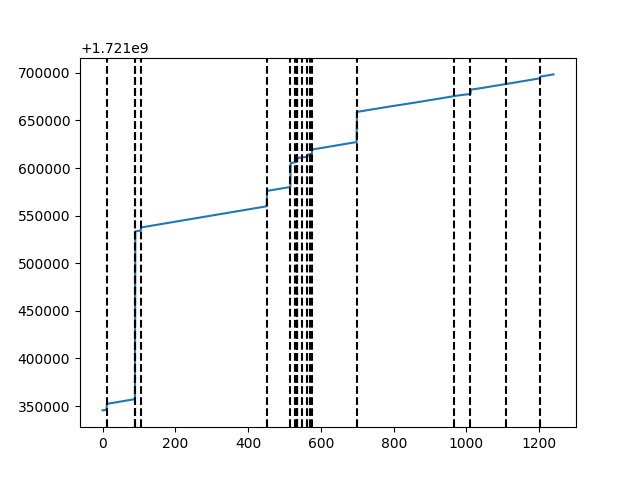

In [6]:
def fname2ts(f):
    t = f[-len("20231014_202203.eig"):-4]
    y = t[:4]
    mo = t[4:6]
    d = t[6:8]
    h = t[9:11]
    mi = t[11:13]
    s = t[13:15]
    dt = datetime.fromisoformat(f"{y}-{mo}-{d} {h}:{mi}:{s}")
    return dt.timestamp()

ftime = np.empty(len(files))
for i, f in enumerate(files):
    ftime[i] = fname2ts(f)
ix = np.argsort(ftime)
ftime = ftime[ix]
files = files[ix]

# observing stops when two files are far apart
breaks = np.argwhere(np.diff(ftime) > np.median(np.diff(ftime))+1)[:, 0]
print(breaks)

plt.figure()
plt.plot(ftime)
for b in breaks:
    plt.axvline(b, ls="--", c="k")
plt.show()

In [7]:
# 0, 1: North Vivaldi (north/east)
# 2, 3: South Vivaldi (north/east)
# 4: brass bicone (north)
# 5: blue bicone (east)

# night 1: box on ground
N1 = np.arange(106, 452)

In [8]:
data = {}
cov = {}
wgt = {}
#for f in files[:120]:
for f in files[N1]:
    hdr, dat = io.read_file(f)
    for k, d in dat.items():
        #if k not in ('3','5','35'):
        #    continue
        if len(k) == 1:
            d.dtype = io.build_dtype(np.uint32, '>')
        data[k] = data.get(k, []) + [d]
for k, v in data.items():
    data[k] = np.concatenate(v, axis=0)

In [9]:
# ncols = 2
# k = '35'
# #k = '3'
# nos_lev = np.sqrt(data[k[0]][:,0,:,0]) * np.sqrt(data[k[-1]][:,0,:,0]) / np.sqrt(hdr['corr_acc_len'] / hdr['nchan'] / 2)
# d = (data[k][:,0]/2 + data[k][:,1]/2).astype(np.float64)
# #d = (data[k][:,0]/2 - data[k][:,1]/2).astype(np.float64)
# if d.shape[-1] > 1:
#     d = d[...,0] + 1j*d[...,1]
# else:
#     d = d[...,0]
# d -= np.median(d, axis=0)

# fig, axes = plt.subplots(ncols=ncols, figsize=(12,12), sharey=True, sharex=True)
# #mx, mn = 7, 3
# mx, mn = 9, 4
# #axes[1].imshow(np.abs(d)/nos_lev, vmax=50., vmin=0, cmap='plasma', interpolation='nearest', aspect='auto')
# #axes[1].imshow(np.log10(np.abs(d)/nos_lev), vmax=2, vmin=0, cmap='plasma', interpolation='nearest', aspect='auto')
# axes[0].imshow(np.log10(np.abs(d)), vmax=mx, vmin=mn, cmap='plasma', interpolation='nearest', aspect='auto')
# axes[1].imshow(np.angle(d), cmap='jet', interpolation='nearest', aspect='auto')
# if ncols == 3:
#     _d = np.fft.fftshift(np.fft.ifft(d, axis=1), axes=1)
#     axes[2].imshow(np.log10(np.abs(_d)), vmax=mx, vmin=mn, cmap='plasma', interpolation='nearest', aspect='auto')


In [19]:
tmin = datetime.fromtimestamp(ftime[N1][0])
tmax = datetime.fromtimestamp(ftime[N1][-1])

In [17]:
tmin.isoformat()

'2024-07-20T21:53:14'

<IPython.core.display.Javascript object>


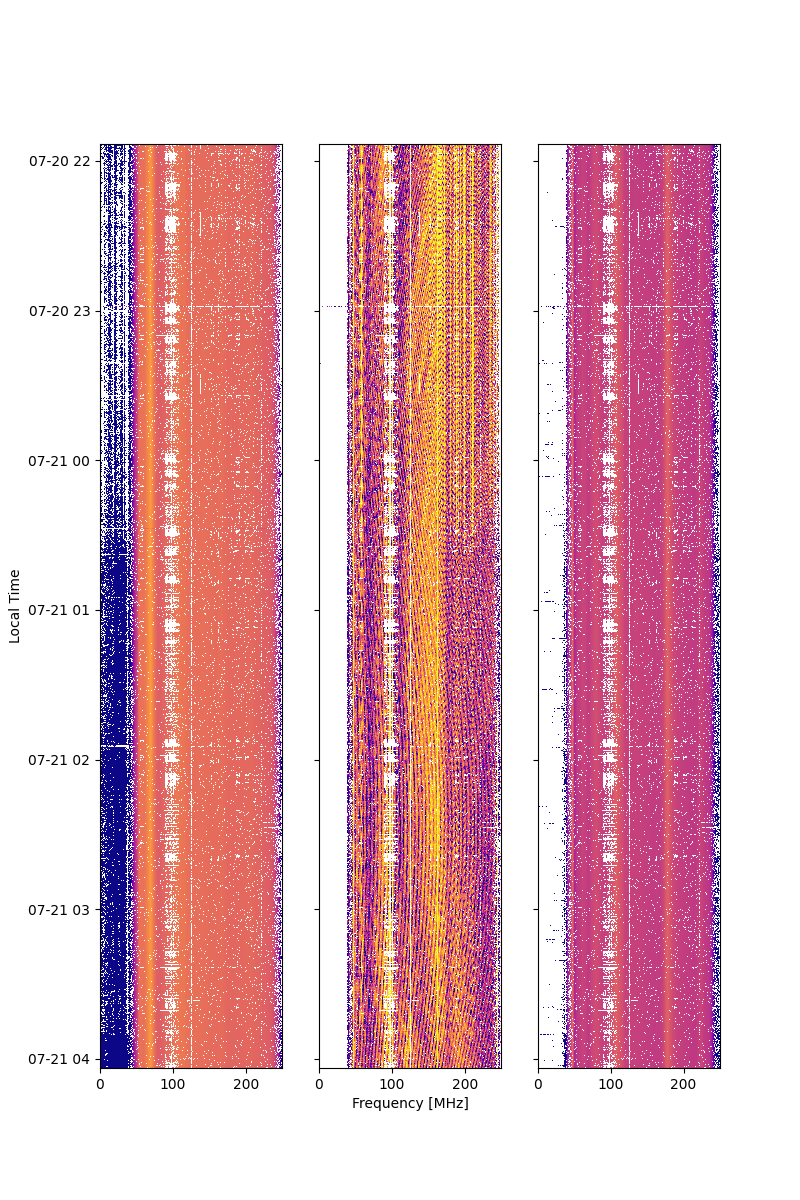

/tmp/ipykernel_11245/1925537285.py:17: RuntimeWarning: divide by zero encountered in divide
  mask[1:-1] = np.where(np.abs(dd12)/diff_nos_lev > 2, 0, 1)
/tmp/ipykernel_11245/1925537285.py:17: RuntimeWarning: invalid value encountered in divide
  mask[1:-1] = np.where(np.abs(dd12)/diff_nos_lev > 2, 0, 1)
/tmp/ipykernel_11245/1925537285.py:26: RuntimeWarning: divide by zero encountered in log10
  axes[0].imshow(np.log10(np.abs(d11*mask)), vmax=mx, vmin=mn, cmap='plasma', interpolation='nearest', aspect='auto', extent=extent)
/tmp/ipykernel_11245/1925537285.py:28: RuntimeWarning: divide by zero encountered in divide
  axes[1].imshow(np.log10(np.abs(d12*mask)/nos_lev), vmax=1, vmin=0, cmap='plasma', interpolation='nearest', aspect='auto', extent=extent)
/tmp/ipykernel_11245/1925537285.py:28: RuntimeWarning: invalid value encountered in divide
  axes[1].imshow(np.log10(np.abs(d12*mask)/nos_lev), vmax=1, vmin=0, cmap='plasma', interpolation='nearest', aspect='auto', extent=extent)
/tmp/ipyke

In [22]:
fig, axes = plt.subplots(ncols=3, figsize=(8,12), sharex=True, sharey=True)
k = "02"
d11 = (data[k[0]][:,0]/2 + data[k[0]][:,1]/2).astype(np.float64)[...,0]
d12 = (data[k][:,0]/2 + data[k][:,1]/2).astype(np.float64)
d22 = (data[k[-1]][:,0]/2 + data[k[-1]][:,1]/2).astype(np.float64)[...,0]
d12 = d12[...,0] + 1j*d12[...,1]
nos_lev = np.sqrt(d11) * np.sqrt(d22) / np.sqrt(hdr["corr_acc_len"] / hdr["nchan"])
extent = [0, 250, tmax, tmin]

if True:
    #d11 -= np.median(d11, axis=0)
    #d12 -= np.median(d12, axis=0)
    #d22 -= np.median(d22, axis=0)
    diff_nos_lev = np.sqrt(0.5**2 + 0.5**2 + 1**2) * nos_lev[1:-1]
    dd12 = d12[1:-1] - 0.5 * (d12[2:] + d12[:-2])
    mask = np.zeros(d11.shape, dtype='int')
    mask[1:-1] = np.where(np.abs(dd12)/diff_nos_lev > 2, 0, 1)
    
if False:
    d11 = np.diff(d11, axis=0)
    d22 = np.diff(d22, axis=0)
    d12 = np.diff(d12, axis=0)
    nos_lev = np.sqrt(nos_lev[1:]**2 + nos_lev[:-1]**2)
    mask = np.where(np.abs(d12)/nos_lev > 2, 0, 1)
mx,mn = 7, 3
axes[0].imshow(np.log10(np.abs(d11*mask)), vmax=mx, vmin=mn, cmap='plasma', interpolation='nearest', aspect='auto', extent=extent)
#axes[1].imshow(np.log10(np.abs(d12*mask)), vmax=mx, vmin=mn, cmap='plasma', interpolation='nearest', aspect='auto')
axes[1].imshow(np.log10(np.abs(d12*mask)/nos_lev), vmax=1, vmin=0, cmap='plasma', interpolation='nearest', aspect='auto', extent=extent)
axes[2].imshow(np.log10(np.abs(d22*mask)), vmax=mx, vmin=mn, cmap='plasma', interpolation='nearest', aspect='auto', extent=extent)
axes[0].set_ylabel("Local Time")
axes[1].set_xlabel("Frequency [MHz]")
plt.show()

<IPython.core.display.Javascript object>


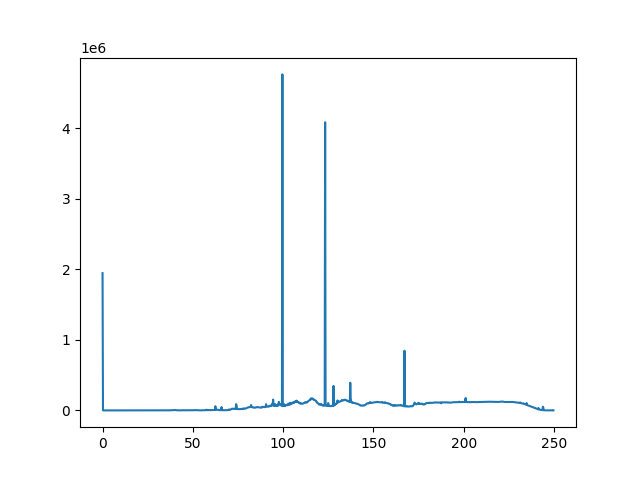

In [8]:
tint = -1  # max is 56580
plt.figure()
plt.plot(freqs/1e6, np.mean(d11[:tint]*mask[:tint], axis=0) / np.mean(mask[:tint], axis=0))
#plt.plot(freqs/1e6, np.abs(np.mean(d12[:tint]*mask[:tint], axis=0)) / np.mean(mask[:tint], axis=0))
#plt.plot(freqs/1e6, np.mean(d11, axis=0))
plt.show()

<IPython.core.display.Javascript object>


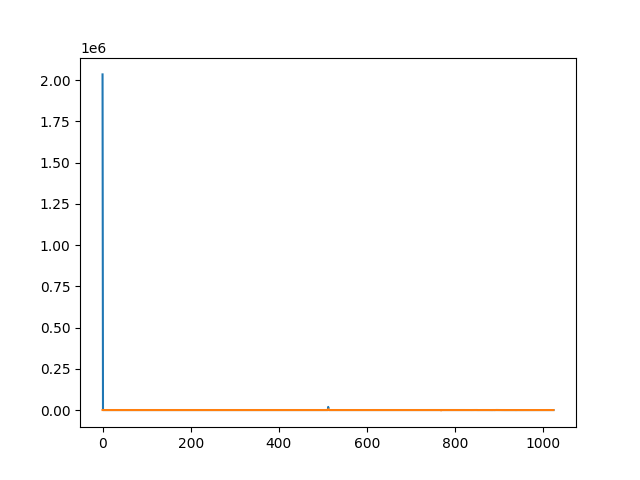

In [9]:
plt.figure()
#plt.plot(freqs, np.mean(mask, axis=0))
#plt.plot(freqs, np.mean(d11*mask, axis=0) / np.mean(mask, axis=0))
#plt.plot(freqs, np.mean(d11*mask, axis=0) / np.mean(mask, axis=0))
plt.plot(np.mean(d12.real*mask, axis=0) / np.mean(mask, axis=0))
plt.plot(np.mean(d12.imag*mask, axis=0) / np.mean(mask, axis=0))
plt.show()

<IPython.core.display.Javascript object>


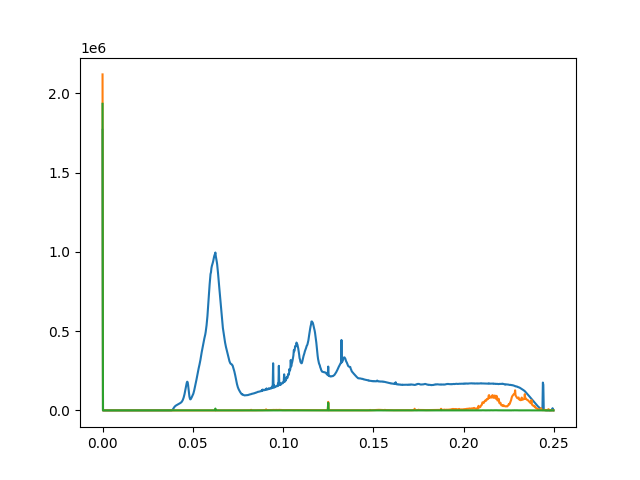

In [11]:
#t = 195  # rfi thing
t = 4000  # fm impulse
plt.figure()
k = '35'
#d11 = (data[k[0]][:,0]/2 + data[k[0]][:,1]/2).astype(np.float64)[...,0]
#d12 = (data[k][:,0]/2 + data[k][:,1]/2).astype(np.float64)
#d22 = (data[k[-1]][:,0]/2 + data[k[-1]][:,1]/2).astype(np.float64)[...,0]
#d12 = d12[...,0] + 1j*d12[...,1]
plt.plot(freqs / 1e9, d11[t])
plt.plot(freqs / 1e9, d22[t])
plt.plot(freqs / 1e9, np.abs(d12[t]))
#plt.plot(freqs / 1e9, d11[t] - d11[t-1])
#plt.plot(freqs / 1e9, d22[t] - d22[t-1])
#plt.plot(freqs / 1e9, np.abs(d12[t] - d12[t-1]))
plt.show()

<IPython.core.display.Javascript object>


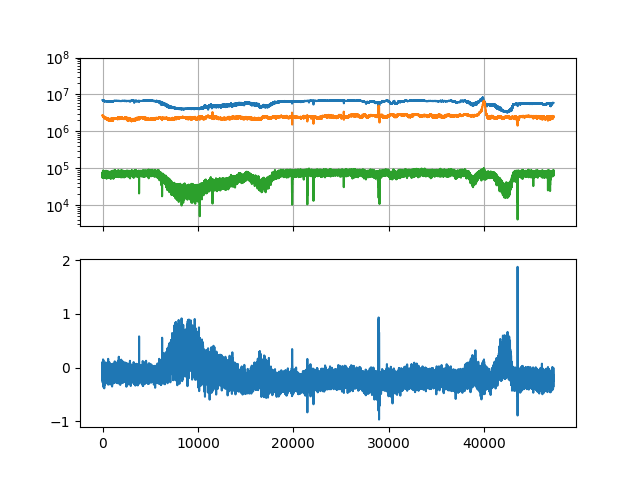

/tmp/ipykernel_9433/4053731656.py:13: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axes[0].set_ylim(-1e8, 1e8)


(2765.1330572073693, 100000000.0)

In [17]:
#ch = 564  # orbcomm
#ch = 401  # fm
ch = 300 # quiet

fig, axes = plt.subplots(nrows=2, sharex=True)
axes[0].plot(np.abs(d11[:,ch]))
axes[0].plot(np.abs(d22[:,ch]))
axes[0].semilogy(np.abs(d12[:,ch]))
#axes[0].plot(d12[:,ch].real)
#axes[0].plot(d12[:,ch].imag)
axes[1].plot(np.angle(d12[:,ch]))
#axes[1].plot(np.angle(d12[:,ch+1]))
axes[0].set_ylim(-1e8, 1e8)
plt.show()

<IPython.core.display.Javascript object>


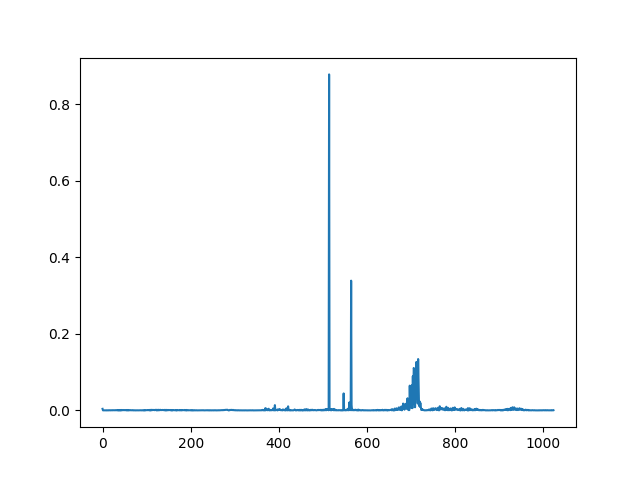

In [206]:
plt.figure()
diff = data['4'][:,0,:,0] - np.median(data['4'][:,0,:,0], axis=0)
#diff = data['4'][:,0,:,0] - data['4'][:,1,:,0]
cov = np.dot(diff.T, diff) / diff.shape[0]
U,S,V = np.linalg.svd(cov)
#plt.plot(S)
plt.plot(np.abs(U[:,5]))
#diag = np.sqrt(np.diag(cov))
#cov /= np.outer(diag, diag)
#plt.imshow(np.log10(np.abs(cov)), vmax=0, vmin=-2, cmap='plasma', interpolation='nearest')
#plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


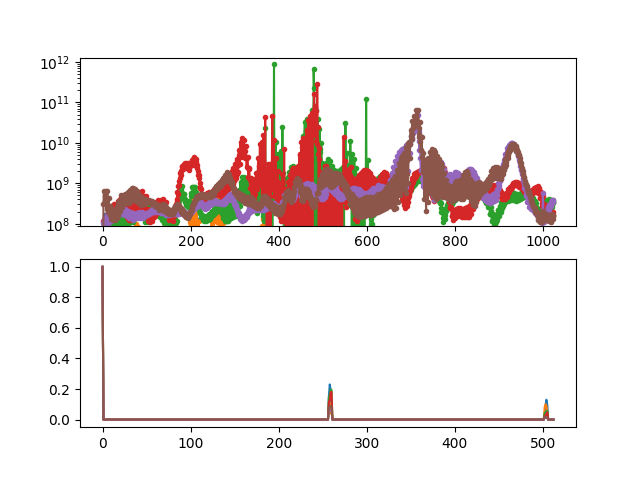

In [93]:
fig, axes = plt.subplots(nrows=2)
for k in data.keys():
    if len(k) > 1: continue
    d = data[k].sum(axis=(0,1,3)).astype(np.float64)
    d[:2] = 0
    _d = np.fft.rfft(d)
    dlys = np.fft.rfftfreq(freqs.size, freqs[1]-freqs[0])
    #_d[np.abs(dlys) > 300e-9] = 0
    _d /= np.abs(_d[0])
    _d[1:257] = 0
    _d[261:502] = 0
    _d[506:] = 0
    d_f = np.fft.irfft(_d) * 500
    #d[2::4] *= np.sqrt(2)
    #d[3::4] *= np.sqrt(2)
    #axes[0].plot(freqs / 1e9, d)
    #axes[0].plot(freqs / 1e9, d_f)
    #axes[0].plot(freqs / 1e9, d)
    axes[0].plot(d / d_f, '.-')
    #axes[1].plot(np.fft.fftshift(dlys) * 1e9, np.fft.fftshift(np.abs(np.fft.fft(d))**2))
    #axes[1].plot(np.fft.fftshift(np.abs(np.fft.fft(d))**2))
    #axes[1].plot(np.fft.fftshift(np.abs(np.fft.fft(d))**2))
    axes[1].plot(np.abs(_d))
#axes[0].set_ylim(0, 2)
#axes[0].set_xlim(256, 280)
plt.show()

[[1.3113732  0.41155542 0.15887603 2.11819536]]
[[ 4.        +0.j          1.15249717+1.70663994j -1.05950155+0.j        ]]


<IPython.core.display.Javascript object>


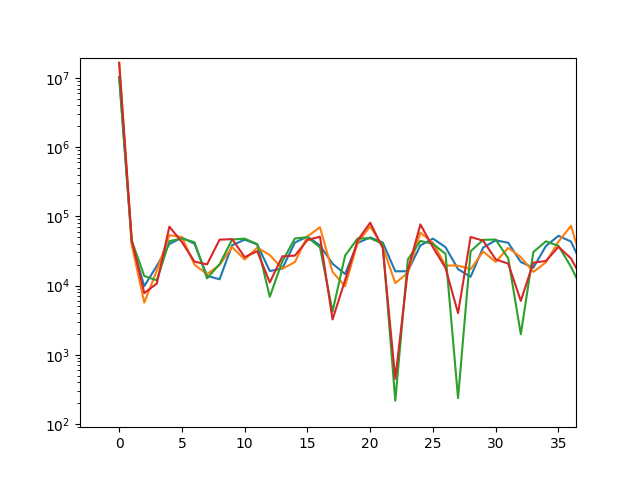

In [142]:
NCHAN = 1024
pwr1a, pwr2a = 0, 0
pwr1b, pwr2b = 0, 0
f = np.random.uniform(size=4).reshape(-1, 4)
f /= f.mean()
print(f)
print(np.fft.rfft(f))
for i in range(10000):
    sig1a = 0.1 * np.sin(2 * np.pi * 50e6 * np.linspace(0, NCHAN * 2e-9, NCHAN, endpoint=False)) +  np.random.normal(size=NCHAN)
    sig1b = 0.1 * np.sin(2 * np.pi * 51e6 * np.linspace(0, NCHAN * 2e-9, NCHAN, endpoint=False)) +  np.random.normal(size=NCHAN)
    sig2a = sig1a.reshape(-1, 4) * f
    sig2b = sig1b.reshape(-1, 4) * f
    pwr1a += np.abs(np.fft.rfft(sig1a))**2
    pwr2a += np.abs(np.fft.rfft(sig2a.flatten()))**2
    pwr1b += np.abs(np.fft.rfft(sig1b))**2
    pwr2b += np.abs(np.fft.rfft(sig2b.flatten()))**2
plt.figure()
#plt.semilogy(pwr1a)
#plt.semilogy(pwr2a)
#plt.semilogy(pwr1b)
#plt.semilogy(pwr2b)
plt.semilogy(np.abs(np.fft.irfft(pwr1a)))
plt.semilogy(np.abs(np.fft.irfft(pwr2a)))
plt.semilogy(np.abs(np.fft.irfft(pwr1b)))
plt.semilogy(np.abs(np.fft.irfft(pwr2b)))
plt.show()

<IPython.core.display.Javascript object>


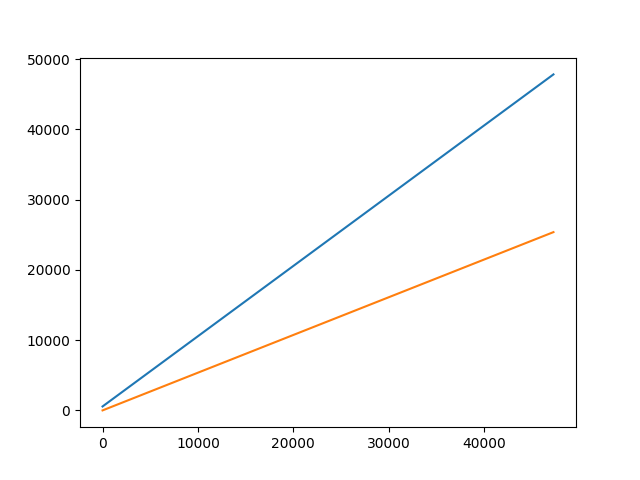

In [34]:
plt.figure()
plt.plot(acc_cnt)
#plt.plot(np.diff(acc_cnt))
plt.plot(times - times[0])